### Task

In [1]:
""" 
Generative Adversarial Text-to-Image Synthesis
In this assignment, you will learn about text-to-image synthesis using conditional GANs. A typical GAN has a
Generator (G) that takes random noise as input to generate realistic data samples (e.g., images or audio or text) and
a Discriminator (D) that acts as a binary classifier, distinguishing between real and generated data. In Conditional
GANs, input to (G) is conditioned over additional information.
In this assignment, you have to train a conditional GAN to generate images where input to Target Generator
(G) is conditioned over textual descriptions. In addition, you have to train a Source Encoder, which will provide
learned representations as input to (G) instead of noise. You may train the whole setup in an end-to-end manner or
in parts. For instance, one approach could be knowledge distillation from source encoder to generator.
Overall Setup:
1. Source Encoder: Takes input image and outputs a representation. Any model size or type.
2. Target Generator: Takes representations from the source model and text encoding to generate new samples.
The number of parameters should be half of that of the Source Encoder. Any model type.
3. Discriminator: Distinguishes between real and generated data. Any model size or type.


Rules:
1. You can use any library to design your GAN.
2. You can use any loss function, coding style, batch size, optimizer or learning rate scheduler.
3. You can use any model architecture except modern ones, such as transformer or diffusion-based models. (If you
are unsure, please ask & clarify first.)
4. You can use the following as base repo for data: https://github.com/aelnouby/Text-to-Image-Synthesis?
tab=readme-ov-file
5. You cannot use any pretrained model/checkpoint, i.e., all parameters in your setup should be trained from
scratch (some random seed).
6. You have to demonstrate your setup by randomly selecting 20 classes (for the train) and 5 classes (for the test)
from the Oxford-102 dataset. Text descriptions are available in the GitHub repo mentioned above.
7. Source encoder can not use class labels during training. You may use any loss function to make it as discriminative
as possible for the real images of all 25 classes.
8. We will only run & test your code on Google Colab. You have a maximum of 200 epochs for training using
Colab resources. Time per epoch doesn’t matter but it is advisable that the training and testing can be finished
within 1 hr (though not mandatory). Hence, choose a resonable model size.
9. We encourage you to save .ipynb file cell outputs such as plots, visualization, loss/acc logs etc to aid in subjective
evaluation component.


Deliverables:
1. We don’t need your trained model but a robust code that can replicate your best setting.
2. Submit a single .ipynb file for this assignment with clean documented code. Beautifully structure your notebook
as if you are given a demo tutorial to a 1st year B.Tech student who can easily follow the steps.
3. Highlight the innovations (new things), if any, you have used that you believe make your submission stand out
and different from the entire class.
4. There should be two separate sections, one for Training and one for Testing.
5. In Training/Testing, you may use the dataloader from the above-mentioned GitHub repo.
6. In Testing, using the best model checkpoint you have to
(a) Generate and plot 5 random images from each test class as a grid of 5x5. (Hint: use diverse unseen text.)
(b) Plot the 3D-tSNE embedding of Source Encoder on all images from both train and test sets.
(c) Print in the form of a table: the total number of parameters, number of trainable parameters and model
size on disk for encoder, generator and discriminator.


[ Input ] −−> [ Source Encoder ] −−> [ Representation] −−> [ Target Generator ] −−> [ Generated Image ]

                                                                      ˆ
                                                                      |
[ Text Inpu t] −−> [ Text Encoder ] −−> [ Text Encoding ] −−−−−−−−−−−−+
[ Generated Image ] −−> [ Di s c rimi n a t o r ] <−−> [ Real Images ]


Marking:
This assignment will not be fully auto-graded. Marking will be manual with subjective evaluations using the
following components:
1. Overall structure & cleanliness of submitted code notebook [1 mark]
2. Successful training of the full GAN model [1 mark]
3. Discriminative ability of the embeddings from Source encoder [1 mark]
4. Subjective diversity and quality of generation [1 mark]
5. Subjective evaluation of innovation in model architecture (including its size and memory footprint) and training
paradigm [1 mark]


"""

' \nGenerative Adversarial Text-to-Image Synthesis\nIn this assignment, you will learn about text-to-image synthesis using conditional GANs. A typical GAN has a\nGenerator (G) that takes random noise as input to generate realistic data samples (e.g., images or audio or text) and\na Discriminator (D) that acts as a binary classifier, distinguishing between real and generated data. In Conditional\nGANs, input to (G) is conditioned over additional information.\nIn this assignment, you have to train a conditional GAN to generate images where input to Target Generator\n(G) is conditioned over textual descriptions. In addition, you have to train a Source Encoder, which will provide\nlearned representations as input to (G) instead of noise. You may train the whole setup in an end-to-end manner or\nin parts. For instance, one approach could be knowledge distillation from source encoder to generator.\nOverall Setup:\n1. Source Encoder: Takes input image and outputs a representation. Any model s

### Code

In [72]:
!pip install torchfile
import torch, torchfile, torchvision
import numpy as np
import scipy
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from sklearn.manifold import TSNE
import os
import io

This cell is there to install the dataset, uncomment and run if you want the notebook to download and unzip

In [ ]:
# !wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
# if not os.path.exists('102flowers/'):
#     os.makedir('102flowers/')
# !tar -xvzf 102flowers.tgz -C 102flowers/

Make the directory structure 
```
102flowers/   
├── jpg/
│   ├── img_00000.jpg
│   ├── img_00001.jpg
│   └── …
flowers_icml/ 
├── class_00001/
│   ├── image_0673xx.t7
│   ├── image_xxxxx.t7
├── class_00002/
│   ├── image_xxxxx.t7
│   └── …
2022310_a3.ipynb
```

Here, flowers_icml is the embeddings folder and 102flowers is the image dataset





In [3]:
PATH_TO_IMAGES='102flowers/jpg/'
PATH_TO_EMBEDDINGS='flowers_icml/'

#### Ensure that the directory structure is maintained


In [ ]:
"""
    Create a directory for training and testing images and embeddings
"""
os.makedirs('train/embeddings/',exist_ok=True)
os.makedirs('test/embeddings',exist_ok=True)
os.makedirs('train/images/',exist_ok=True)
os.makedirs('test/images/',exist_ok=True)


In [71]:
EMBEDDINGS_TEST_PATH='test/embeddings/'
EMBEDDINGS_TRAIN_PATH='train/embeddings/'

In [4]:
labels=scipy.io.loadmat('imagelabels.mat')
labels=labels['labels']
labels=torch.tensor(labels)
labels=labels.squeeze() 
labels, labels.shape

(tensor([77, 77, 77,  ..., 62, 62, 62], dtype=torch.uint8), torch.Size([8189]))

In [5]:
classes=torch.unique(labels)
classes

tensor([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
         43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
         57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
         71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
         99, 100, 101, 102], dtype=torch.uint8)

In [6]:
torch.manual_seed(0);
"""   
    Randomly Select 20 classes for training and 5 classes for testing
"""
permutation=torch.randperm(102)+1
train_classes=permutation[:20]
test_classes=permutation[20:25]
train_classes,test_classes


(tensor([93, 63, 36, 73, 20, 66, 74,  3, 32, 58, 80, 75, 19, 12, 45, 54, 89, 41,
          1, 67]),
 tensor([14, 33, 94, 11, 99]))

In [ ]:
"""  
    FIll in the directories with images and embeddings
"""
for i in range(1,8190):
    label_index=i-1
    label=labels[label_index]
    number="{:05d}".format(i)
    if label in train_classes:
        img=torchvision.io.read_image(PATH_TO_IMAGES+"image_"+number+'.jpg')
        img=torchvision.transforms.Resize((128,128))(img)
        torchvision.io.write_jpeg(img,'train/images/'+str(label.item())+'_'+number+'.jpg')
    elif label in test_classes:
        img=torchvision.io.read_image(PATH_TO_IMAGES+"image_"+number+'.jpg')
        img=torchvision.transforms.Resize((128,128))(img)
        torchvision.io.write_jpeg(img,'test/images/'+str(label.item())+'_'+number+'.jpg')



In [ ]:
""" Train embeddings"""
for i in train_classes:
    class_name="{:05d}".format(i.item())
    
    class_embeddings_folder=PATH_TO_EMBEDDINGS+'class_'+class_name+'/'
    for file in os.listdir(class_embeddings_folder):
        #extract img number from name
        img_number=file.split('_')[1].split('.')[0]
        # print(img_number)
        embeddings=torchfile.load(class_embeddings_folder+file)[b'txt']
        #convert to tensor
        embeddings=torch.tensor(embeddings)
        #save tensor
        torch.save(embeddings,EMBEDDINGS_TRAIN_PATH+str(i.item())+'_'+img_number+'.pt')
        
    
        

In [ ]:
# collect the embedding
""" Test embeddings"""
for i in test_classes:
    class_name="{:05d}".format(i.item())
    
    class_embeddings_folder=PATH_TO_EMBEDDINGS+'class_'+class_name+'/'
    for file in os.listdir(class_embeddings_folder):
        #extract img number from name
        img_number=file.split('_')[1].split('.')[0]
        # print(img_number)
        embeddings=torchfile.load(class_embeddings_folder+file)[b'txt']
        #convert to tensor
        embeddings=torch.tensor(embeddings)
        #save tensor
        torch.save(embeddings,EMBEDDINGS_TEST_PATH+str(i.item())+'_'+img_number+'.pt')

In [11]:
train_imgs=[]
train_embeddings=[]
test_imgs=[]
test_embeddings=[]
train_labels=[] 
test_labels=[]

In [ ]:
"""Load the images,labels and embeddings"""
for img in os.listdir('train/images/'):
    train_imgs.append(torchvision.io.read_image('train/images/'+img))
    train_labels.append(int(img.split('_')[0]))

for emb in os.listdir('train/embeddings/'):
    train_embeddings.append(torch.load('train/embeddings/'+emb))

for img in os.listdir('test/images/'):
    test_imgs.append(torchvision.io.read_image('test/images/'+img))
    test_labels.append(int(img.split('_')[0]))

for emb in os.listdir('test/embeddings/'):
    test_embeddings.append(torch.load('test/embeddings/'+emb))


In [13]:
len(train_imgs),len(train_embeddings),len(test_imgs),len(test_embeddings), len(train_labels), len(test_labels)

(1711, 1711, 406, 406, 1711, 406)

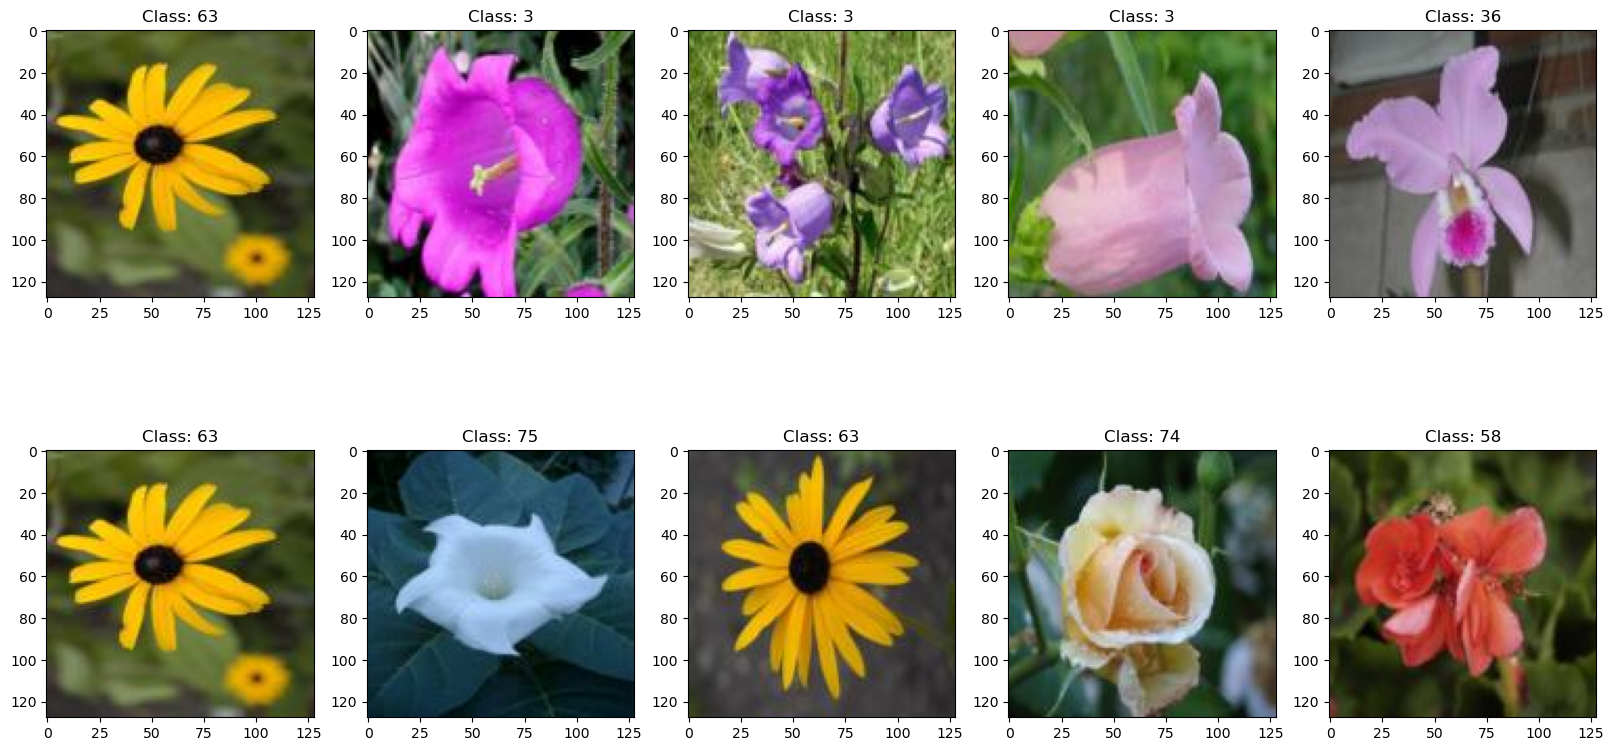

In [14]:
"""VIsualise the dataset"""
fig,ax=plt.subplots(2,5,figsize=(20,10))
for i in range(5):
    ax[0,i].imshow(train_imgs[i].permute(1,2,0))
    ax[0,i].set_title('Class: '+str(train_labels[i]))
    ax[1,i].imshow(train_imgs[i*5].permute(1,2,0))
    ax[1,i].set_title('Class: '+str(train_labels[i*5]))
plt.show()

In [15]:
train_imgs=torch.tensor(torch.stack(train_imgs))
train_embeddings=torch.tensor(torch.stack(train_embeddings))
test_imgs=torch.tensor(torch.stack(test_imgs))   
test_embeddings=torch.tensor(torch.stack(test_embeddings))
train_labels=torch.tensor(train_labels)
test_labels=torch.tensor(test_labels)

train_imgs.shape,train_embeddings.shape,test_imgs.shape,test_embeddings.shape,train_labels.shape,test_labels.shape

/tmp/ipykernel_2677088/4253432787.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_imgs=torch.tensor(torch.stack(train_imgs))
/tmp/ipykernel_2677088/4253432787.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings=torch.tensor(torch.stack(train_embeddings))
/tmp/ipykernel_2677088/4253432787.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_imgs=torch.tensor(torch.stack(test_imgs))
/tmp/ipykernel_2677088/4253432787.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone

(torch.Size([1711, 3, 128, 128]),
 torch.Size([1711, 10, 1024]),
 torch.Size([406, 3, 128, 128]),
 torch.Size([406, 10, 1024]),
 torch.Size([1711]),
 torch.Size([406]))

In [16]:
train_imgs = train_imgs.float() / 255.0
test_imgs = test_imgs.float() / 255.0


### Model Architectures

In [ ]:
class ResidualBlock(torch.nn.Module):
    """
    Implements a basic residual block as used in ResNet architectures.

    This block consists of two 3x3 convolutional layers each followed by batch normalization
    and a ReLU activation. A skip (identity) connection adds the input to the output of the second
    convolution. When the input and output dimensions differ—due to a change in the number of channels
    or a stride greater than 1—a downsampling layer (a 1x1 convolution with batch normalization) is applied
    to the input to match the dimensions.

    Parameters:
        in_channels (int): Number of channels in the input tensor.
        out_channels (int): Number of channels produced by this block.
        stride (int, optional): Stride for the first convolutional layer. Default is 1.
        dilation (int, optional): Dilation rate for the convolutions. Default is 1.

    Forward:
        x (Tensor): Input tensor of shape (N, in_channels, H, W).

    Returns:
        Tensor: Output tensor of shape (N, out_channels, H_out, W_out), where H_out and W_out depend on
                the stride and dilation parameters.

    """

    def __init__(self, in_channels, out_channels, stride=1, dilation=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=dilation,
            dilation=dilation,
            bias=False,
        )
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = torch.nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=dilation,
            dilation=dilation,
            bias=False,
        )
        self.bn2 = torch.nn.BatchNorm2d(out_channels)

        # Downsample if needed
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = torch.nn.Sequential(
                torch.nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=stride, bias=False
                ),
                torch.nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)
        return out

In [ ]:
class InceptionBlock(torch.nn.Module):
    """
    An Inception block that performs multi-scale feature extraction using parallel convolutional branches.

    This block applies three parallel convolutions to the input:
      - A 1x1 convolution (branch1)
      - A 3x3 convolution with padding=1 (branch2)
      - A 5x5 convolution with padding=2 (branch3)

    The number of output channels is split approximately equally among the three branches.
    Any remainder (if out_channels is not divisible by 3) is added to the output channels of branch3.
    The outputs from all branches are concatenated along the channel dimension, followed by batch
    normalization and a ReLU activation.

    Parameters:
        in_channels (int): The number of channels in the input tensor.
        out_channels (int): The desired number of output channels after concatenation.
                              This value is divided among the three branches.

    Forward:
        x (Tensor): Input tensor of shape (N, in_channels, H, W).

    Returns:
        Tensor: Output tensor of shape (N, out_channels, H, W).

    """

    def __init__(self, in_channels, out_channels):
        super(InceptionBlock, self).__init__()
        branch_channels = out_channels // 3
        remainder = out_channels - (branch_channels * 3)

        self.branch1 = torch.nn.Conv2d(
            in_channels, branch_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.branch2 = torch.nn.Conv2d(
            in_channels, branch_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.branch3 = torch.nn.Conv2d(
            in_channels,
            branch_channels + remainder,
            kernel_size=5,
            stride=1,
            padding=2,
            bias=False,
        )

        self.bn = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat([x1, x2, x3], dim=1)
        out = self.bn(out)
        out = self.relu(out)
        return out

In [ ]:
class SourceEncoder(torch.nn.Module):
    """
    A convolutional encoder that extracts a compact feature representation from input images.

    This module processes images of shape [batch, 3, 128, 128] through an initial convolution, followed by a series
    of residual layers and inception blocks to gradually increase the number of channels and reduce spatial dimensions.
    It then applies further downsampling and global average pooling before projecting the features to a fixed-size
    output vector of dimension `output_dim` via a fully connected layer.

    The architecture flow is as follows:
      1. Initial convolution (`conv1`) with batch normalization and ReLU activation.
      2. Four residual layers (`layer1` to `layer4`), where:
         - `layer1` retains the spatial resolution (128x128).
         - `layer2` downsamples from 128x128 to 64x64.
         - `layer3` downsamples from 64x64 to 32x32.
         - `layer4` downsamples from 32x32 to 16x16.
      3. Two Inception blocks (`inception1` and `inception2`) operating on the 16x16 feature maps.
      4. An additional convolution (`conv2`) downsamples the 16x16 feature map to 8x8, followed by batch norm and ReLU.
      5. Global average pooling collapses the spatial dimensions to 1x1.
      6. A fully connected layer (`fc`) projects the flattened features to a vector of size `output_dim`.

    Parameters:
        output_dim (int): The dimension of the final output feature vector. Default is 1024.
    """
    def __init__(self, output_dim=1024):
        super(SourceEncoder, self).__init__()
        self.in_channels = 64
        # Initial conv layer for [3,128,128]
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.relu = torch.nn.ReLU(inplace=True)
        
        # Residual layers:
        # After conv1: [64, 128,128]
        self.layer1 = self._make_layer(64, 2, stride=1, dilation=1)   # remains 128x128
        self.layer2 = self._make_layer(128, 2, stride=2, dilation=2)    # 128x128 -> 64x64
        self.layer3 = self._make_layer(256, 2, stride=2, dilation=2)    # 64x64 -> 32x32
        self.layer4 = self._make_layer(512, 2, stride=2, dilation=1)    # 32x32 -> 16x16
        
        # Inception blocks (maintaining channels):
        self.inception1 = InceptionBlock(512, 512)  # 16x16 remains 16x16
        self.inception2 = InceptionBlock(512, 512)  # 16x16 remains 16x16
        
        # Further downsampling: 16x16 -> 8x8
        self.conv2 = torch.nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(1024)
        self.relu2 = torch.nn.ReLU(inplace=True)
        
        # Global average pooling to get [1024,1,1]
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully connected layer to project to output_dim
        
        self.fc = torch.nn.Linear(1024, output_dim)
        
    def _make_layer(self, out_channels, blocks, stride, dilation):
        """
        Constructs a sequential layer consisting of multiple ResidualBlocks.

        This helper function creates a sequential module where the first block in the layer
        can change the spatial dimensions (via stride) and/or the number of channels, and the
        subsequent blocks preserve these dimensions.

        Parameters:
            out_channels (int): The number of output channels for the blocks in this layer.
            blocks (int): The number of ResidualBlocks to stack.
            stride (int): The stride for the first block, which determines the downsampling rate.
            dilation (int): The dilation factor for the convolutions in these blocks.

        Returns:
            torch.nn.Sequential: A sequential container of ResidualBlocks.
        """
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, dilation))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels, 1, dilation))
        return torch.nn.Sequential(*layers)
    
    def forward(self, x):
        # x: [batch, 3, 128, 128]
        x = self.conv1(x)       # -> [64, 128,128]
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)      # -> [64, 128,128]
        x = self.layer2(x)      # -> [128, 64,64]
        x = self.layer3(x)      # -> [256, 32,32]
        x = self.layer4(x)      # -> [512, 16,16]
        
        x = self.inception1(x)  # -> [512, 16,16]
        x = self.inception2(x)  # -> [512, 16,16]
        
        x = self.conv2(x)       # -> [1024, 8,8]
        x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.avgpool(x)     # -> [1024, 1,1]
        x = torch.flatten(x, 1) # -> [batch, 1024]
        x = self.fc(x)          # -> [batch, output_dim]
        return x

In [ ]:
class Generator(torch.nn.Module):
    """
    Generator network for a GAN that transforms a latent vector into an image.

    This module projects an input latent vector of dimension `input_dim` to a low-resolution
    feature map and then progressively upsamples it through a series of transposed convolution
    (deconvolution) layers. The output image has dimensions [img_channels, 128, 128] and its pixel
    values are scaled to the range [-1, 1] via a Tanh activation.

    Architecture:
        1. A fully connected (linear) layer projects the latent vector to a feature map of shape
           [feature_maps, 8, 8].
        2. Four deconvolutional blocks upsample the feature map:
           - deconv1: Upsamples from 8x8 to 16x16.
           - deconv2: Upsamples from 16x16 to 32x32.
           - deconv3: Upsamples from 32x32 to 64x64.
           - deconv4: Upsamples from 64x64 to 128x128 and applies Tanh activation.

    Parameters:
        input_dim (int): Dimensionality of the input latent vector. Default is 2048.
        img_channels (int): Number of channels in the generated output image (e.g., 3 for RGB). Default is 3.
        feature_maps (int): Base number of feature maps for the initial projection. This determines
                            the number of channels in the feature map before upsampling. Default is 64.

    Forward Pass:
        Args:
            x (Tensor): Input latent tensor of shape [batch_size, input_dim].

        Returns:
            Tensor: Generated image tensor of shape [batch_size, img_channels, 128, 128] with values in [-1, 1].

    """

    def __init__(self, input_dim=2048, img_channels=3, feature_maps=64):
        super(Generator, self).__init__()
        # Project latent vector to a feature map of shape [feature_maps, 8, 8]
        self.fc = torch.nn.Linear(input_dim, feature_maps * 8 * 8)

        # Upsampling blocks:
        # 8x8 -> 16x16
        self.deconv1 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                feature_maps,
                feature_maps // 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            torch.nn.BatchNorm2d(feature_maps // 2),
            torch.nn.LeakyReLU(inplace=True),
        )
        # 16x16 -> 32x32
        self.deconv2 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                feature_maps // 2,
                feature_maps // 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            torch.nn.BatchNorm2d(feature_maps // 4),
            torch.nn.LeakyReLU(inplace=True),
        )
        # 32x32 -> 64x64
        self.deconv3 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                feature_maps // 4,
                feature_maps // 8,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            torch.nn.BatchNorm2d(feature_maps // 8),
            torch.nn.LeakyReLU(inplace=True),
        )
        # 64x64 -> 128x128
        self.deconv4 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                feature_maps // 8,
                img_channels,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            torch.nn.Tanh(),  # Scale outputs to [-1, 1]
        )

    def forward(self, x):
        # x: [batch, input_dim]
        x = self.fc(x)
        x = x.view(x.size(0), -1, 8, 8)  # Reshape to [batch, feature_maps, 8, 8]
        x = self.deconv1(x)  # -> [batch, feature_maps//2, 16, 16]
        x = self.deconv2(x)  # -> [batch, feature_maps//4, 32, 32]
        x = self.deconv3(x)  # -> [batch, feature_maps//8, 64, 64]
        x = self.deconv4(x)  # -> [batch, img_channels, 128, 128]
        return x

In [ ]:
class Discriminator(torch.nn.Module):
    """

    A convolutional discriminator (critic) for GANs that distinguishes real from generated images.

    This network takes an image tensor of shape [batch, in_channels, 128, 128] and outputs a scalar
    for each image. The architecture progressively downsamples the input image through a series of 
    convolutional layers with LeakyReLU activations and Batch Normalization (except in the first layer).
    The final convolutional layer collapses the spatial dimensions to produce a single output per image.

    Architecture:
      1. Convolution with kernel size 4, stride 2, padding 1 to downsample from 128x128 to 64x64,
         followed by LeakyReLU.
      2. Convolution from 64 to 128 channels, downsampling from 64x64 to 32x32, followed by BatchNorm2d and LeakyReLU.
      3. Convolution from 128 to 256 channels, downsampling from 32x32 to 16x16, followed by BatchNorm2d and LeakyReLU.
      4. Convolution from 256 to 512 channels, downsampling from 16x16 to 8x8, followed by BatchNorm2d and LeakyReLU.
      5. A final convolution with kernel size 8 (and no padding) that collapses the 8x8 feature map to 1x1,
         producing a single scalar output per image.

    Parameters:
        in_channels (int): Number of channels in the input images (e.g., 3 for RGB images).

    Forward:
        Args:
            x (Tensor): Input tensor of shape [batch, in_channels, 128, 128].

        Returns:
            Tensor: A tensor of shape [batch, 1] containing the discriminator scores for each image.
    """

    
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        self.model = torch.nn.Sequential(
            # Input: (in_channels, 128, 128)
            torch.nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),  # -> (64, 64, 64)
            torch.nn.LeakyReLU(0.2, inplace=True),
            
            torch.nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),  # -> (128, 32, 32)
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.2, inplace=True),
            
            torch.nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),  # -> (256, 16, 16)
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(0.2, inplace=True),
            
            torch.nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),  # -> (512, 8, 8)
            torch.nn.BatchNorm2d(512),
            torch.nn.LeakyReLU(0.2, inplace=True),
            
            # Final conv: collapse 8x8 to 1x1
            torch.nn.Conv2d(512, 1, kernel_size=8, stride=1, padding=0, bias=False)  # -> (1, 1, 1)
        )

    def forward(self, x):
        out = self.model(x)
        out = out.view(x.size(0), -1)  # Flatten to shape [batch_size, 1]
        # out=torch.sigmoid(out)
        return out

In [ ]:
class ImageDataset(torch.utils.data.Dataset):
    """
        A custom PyTorch Dataset for loading images and their corresponding embeddings.
    """
    def __init__(self, images, embeddings, labels):
        self.images = images
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        """
            Returns the number of samples in the dataset.
        """
        return len(self.images)

    def __getitem__(self, idx):
        """
            Returns the image, embedding, and label for the given index.
        """
        return self.images[idx], self.embeddings[idx], self.labels[idx]

In [26]:
train_dataset = ImageDataset(train_imgs, train_embeddings, train_labels)
test_dataset = ImageDataset(test_imgs, test_embeddings, test_labels)

In [27]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [59]:
""" initialize the models"""

sourceEncoder=SourceEncoder().to(device)
generator=Generator().to(device)
discriminator=Discriminator(3).to(device)

In [60]:
""" initialize the dataloaders"""
train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=False)


## Training Section

In [63]:
def train_conditional_gan(epochs, dataloader, source_encoder, generator, discriminator, device):
    """
    Trains a Conditional Generative Adversarial Network (GAN) consisting of a source encoder, 
    generator, and discriminator. The training follows the adversarial framework where the 
    discriminator learns to distinguish real from generated images, while the generator 
    (along with the source encoder) learns to generate realistic images conditioned on 
    text embeddings.

    Training Pipeline:
        1. The discriminator is trained to maximize its ability to classify real images as real 
           and generated images as fake.
        2. The generator and source encoder are trained together to generate realistic images 
           that fool the discriminator.
        3. Losses for both the discriminator and generator+source encoder are tracked and averaged 
           per epoch.
        4. At every 20 epochs, generated images are visualized.

    Parameters:
        epochs (int): Number of training epochs.
        dataloader (DataLoader): DataLoader providing batches of (images, text_embeddings, labels).
        source_encoder (torch.nn.Module): The source encoder network that extracts feature representations from images.
        generator (torch.nn.Module): The generator network that synthesizes images from latent vectors.
        discriminator (torch.nn.Module): The discriminator network that distinguishes real from generated images.
        device (torch.device): The device (CPU/GPU) to run the training on.

    Forward Pass:
        - The source encoder extracts features from real images.
        - The extracted features are concatenated with the corresponding text embeddings.
        - The generator takes the concatenated vector as input and synthesizes an image.
        - The discriminator evaluates both real and generated images to compute losses.
        - The discriminator is updated separately from the generator and source encoder.

    Loss Functions:
        - `torch.nn.BCEWithLogitsLoss()`: Binary cross-entropy loss used for adversarial training.
        - The discriminator is trained to maximize the difference between real and fake images.
        - The generator and source encoder are trained to generate images that fool the discriminator.

    Optimizers:
        - `Adam` optimizer is used for both the discriminator and the generator+source encoder 
          with learning rate `0.002` and betas `(0.5, 0.999)`.

    Training Steps:
        - For each batch:
            1. Compute discriminator loss using real and fake images.
            2. Backpropagate and update discriminator weights.
            3. Compute generator+source encoder loss.
            4. Backpropagate and update generator+source encoder weights.
        - Losses are stored for visualization.
        - Every 20 epochs, generated images are displayed.

    Visualization:
        - After every 20 epochs, a set of generated images is displayed.
        - At the end of training, loss curves are plotted for the discriminator and generator+source encoder.


    """

    # Set models to train mode
    source_encoder.train()
    generator.train()
    discriminator.train()

    criterion1 = torch.nn.BCEWithLogitsLoss()
    criterion2 = torch.nn.MSELoss()
    # criterion3= torch.nn.L1Loss()

    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_G_SE = torch.optim.Adam(
        list(generator.parameters()) + list(source_encoder.parameters()),
        lr=0.0002, betas=(0.5, 0.999))

    # Lists to track average losses per epoch
    disc_losses_epoch = []
    gen_se_losses_epoch = []

    # Fixed sample for visualization
    fixed_batch = next(iter(dataloader))
    fixed_images, fixed_text_embeddings, _ = fixed_batch
    fixed_images = fixed_images.to(device)
    fixed_text_embeddings = fixed_text_embeddings.to(device)
    # If fixed_text_embeddings have an extra dimension, select the first embedding along that dimension.
    if fixed_text_embeddings.dim() == 3:
        fixed_text_embeddings = fixed_text_embeddings[:, 0, :]

    dataset_size = len(dataloader.dataset)

    for epoch in range(epochs):
        epoch_loss_D = 0.0
        epoch_loss_G_SE = 0.0
        total_samples = 0

        for batch_idx, (images, text_embeddings, labels) in enumerate(dataloader):
            batch_size = images.size(0)
            total_samples += batch_size

            images = images.to(device)
            text_embeddings = text_embeddings.to(device)
            # Ensure text_embeddings is 2D: [B, 1024]
            if text_embeddings.dim() == 3:
                text_embeddings = text_embeddings[:, 0, :]

            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            # ----- Train Discriminator -----
            optimizer_D.zero_grad()
            outputs_real = discriminator(images)
            loss_real = criterion1(outputs_real, real_labels)
            loss_real2=criterion2(outputs_real,real_labels)
            # loss_real3=criterion3(outputs_real,real_labels)

            features = source_encoder(images)  
            # print(features.shape, text_embeddings.shape)
            latent = torch.cat([features, text_embeddings], dim=1)  
            fake_images = generator(latent)
            outputs_fake = discriminator(fake_images.detach())
            loss_fake = criterion1(outputs_fake, fake_labels)
            loss_fake2=criterion2(outputs_fake,fake_labels)
            # loss_fake3=criterion3(outputs_fake,fake_labels)
            loss_D = loss_real + loss_fake + loss_real2 + loss_fake2 #+ loss_real3 + loss_fake3
            loss_D.backward()
            optimizer_D.step()

            # ----- Train Generator and Source Encoder -----
            optimizer_G_SE.zero_grad()
            features = source_encoder(images)
            latent = torch.cat([features, text_embeddings], dim=1)
            fake_images = generator(latent)
            outputs_fake = discriminator(fake_images)
            loss_G_SE1 = criterion1(outputs_fake, real_labels)
            loss_G_SE2=criterion2(outputs_fake,real_labels)
            # loss_G_SE3=criterion3(outputs_fake,real_labels)
            loss_G_SE = loss_G_SE1 + loss_G_SE2 #+ loss_G_SE3
            loss_G_SE.backward()
            optimizer_G_SE.step()

            # Accumulate losses weighted by batch size
            epoch_loss_D += loss_D.item() * batch_size
            epoch_loss_G_SE += loss_G_SE.item() * batch_size

            if batch_idx % 50 == 0:
                print(f"Epoch [{epoch+1}/{epochs}] Batch [{batch_idx}/{len(dataloader)}] "
                      f"D_loss: {loss_D.item():.4f}, G+SE_loss: {loss_G_SE.item():.4f}")

        # Compute average losses for the epoch
        avg_loss_D = epoch_loss_D / total_samples
        avg_loss_G_SE = epoch_loss_G_SE / total_samples
        disc_losses_epoch.append(avg_loss_D)
        gen_se_losses_epoch.append(avg_loss_G_SE)
        print(f"Epoch [{epoch+1}/{epochs}] Avg D_loss: {avg_loss_D:.4f}, Avg G+SE_loss: {avg_loss_G_SE:.4f}")

        # ----- Visualization at the End of Each 20 Epochs -----
        if(epoch % 20 == 0):
            with torch.no_grad():
                fixed_features = source_encoder(fixed_images)
                fixed_latent = torch.cat([fixed_features, fixed_text_embeddings], dim=1)
                gen_images = generator(fixed_latent)
                gen_images = (gen_images + 1) / 2  # Convert from [-1,1] to [0,1]
                grid = vutils.make_grid(gen_images, nrow=4, padding=2)
                plt.figure(figsize=(8,8))
                plt.axis("off")
                plt.title(f"Epoch {epoch+1}")
                plt.imshow(grid.permute(1,2,0).cpu().numpy())
                plt.show()

    # ----- Plot Loss Curves -----
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(10,5))
    plt.plot(epochs_range, disc_losses_epoch, label="Discriminator Loss")
    plt.plot(epochs_range, gen_se_losses_epoch, label="Generator+SourceEncoder Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curves")
    plt.legend()
    plt.show()


Epoch [1/200] Batch [0/54] D_loss: 2.4061, G+SE_loss: 0.9427
Epoch [1/200] Batch [50/54] D_loss: 1.7040, G+SE_loss: 8.2607
Epoch [1/200] Avg D_loss: 2.8087, Avg G+SE_loss: 8.8205


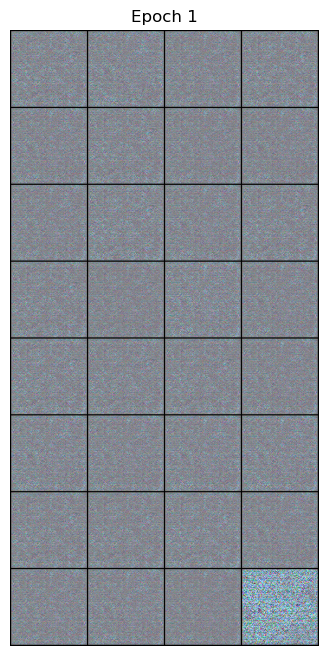

Epoch [2/200] Batch [0/54] D_loss: 2.4248, G+SE_loss: 6.5453
Epoch [2/200] Batch [50/54] D_loss: 1.5288, G+SE_loss: 2.2515
Epoch [2/200] Avg D_loss: 1.5789, Avg G+SE_loss: 3.5549
Epoch [3/200] Batch [0/54] D_loss: 1.0967, G+SE_loss: 2.8422
Epoch [3/200] Batch [50/54] D_loss: 2.0795, G+SE_loss: 6.6597
Epoch [3/200] Avg D_loss: 1.5053, Avg G+SE_loss: 3.1720
Epoch [4/200] Batch [0/54] D_loss: 1.3369, G+SE_loss: 2.1203
Epoch [4/200] Batch [50/54] D_loss: 1.4077, G+SE_loss: 1.6500
Epoch [4/200] Avg D_loss: 1.3150, Avg G+SE_loss: 2.8115
Epoch [5/200] Batch [0/54] D_loss: 1.9504, G+SE_loss: 4.3207
Epoch [5/200] Batch [50/54] D_loss: 1.0808, G+SE_loss: 2.5436
Epoch [5/200] Avg D_loss: 1.3526, Avg G+SE_loss: 2.8435
Epoch [6/200] Batch [0/54] D_loss: 1.7157, G+SE_loss: 2.2811
Epoch [6/200] Batch [50/54] D_loss: 1.1033, G+SE_loss: 2.3359
Epoch [6/200] Avg D_loss: 1.3472, Avg G+SE_loss: 2.6717
Epoch [7/200] Batch [0/54] D_loss: 1.1701, G+SE_loss: 2.3503
Epoch [7/200] Batch [50/54] D_loss: 1.3004, 

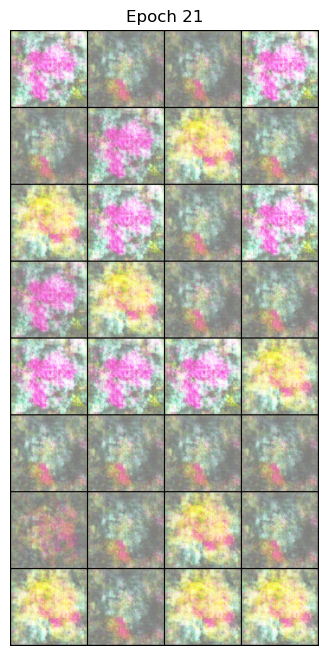

Epoch [22/200] Batch [0/54] D_loss: 1.0352, G+SE_loss: 3.3552
Epoch [22/200] Batch [50/54] D_loss: 3.8958, G+SE_loss: 0.7280
Epoch [22/200] Avg D_loss: 1.6973, Avg G+SE_loss: 2.9145
Epoch [23/200] Batch [0/54] D_loss: 1.4968, G+SE_loss: 3.0511
Epoch [23/200] Batch [50/54] D_loss: 2.3151, G+SE_loss: 0.6535
Epoch [23/200] Avg D_loss: 1.8545, Avg G+SE_loss: 2.9655
Epoch [24/200] Batch [0/54] D_loss: 1.5959, G+SE_loss: 2.9580
Epoch [24/200] Batch [50/54] D_loss: 1.5260, G+SE_loss: 0.9985
Epoch [24/200] Avg D_loss: 1.7429, Avg G+SE_loss: 2.6275
Epoch [25/200] Batch [0/54] D_loss: 1.6603, G+SE_loss: 3.9888
Epoch [25/200] Batch [50/54] D_loss: 1.8781, G+SE_loss: 5.4393
Epoch [25/200] Avg D_loss: 1.7125, Avg G+SE_loss: 2.6896
Epoch [26/200] Batch [0/54] D_loss: 1.0510, G+SE_loss: 2.7106
Epoch [26/200] Batch [50/54] D_loss: 2.5625, G+SE_loss: 1.4091
Epoch [26/200] Avg D_loss: 1.6658, Avg G+SE_loss: 2.8776
Epoch [27/200] Batch [0/54] D_loss: 1.2775, G+SE_loss: 1.8097
Epoch [27/200] Batch [50/54]

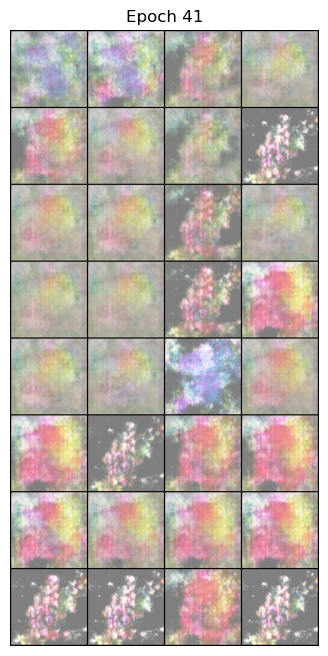

Epoch [42/200] Batch [0/54] D_loss: 1.4427, G+SE_loss: 3.1407
Epoch [42/200] Batch [50/54] D_loss: 1.0468, G+SE_loss: 2.6938
Epoch [42/200] Avg D_loss: 1.2329, Avg G+SE_loss: 2.4661
Epoch [43/200] Batch [0/54] D_loss: 1.7009, G+SE_loss: 0.6057
Epoch [43/200] Batch [50/54] D_loss: 1.2217, G+SE_loss: 2.5858
Epoch [43/200] Avg D_loss: 1.4751, Avg G+SE_loss: 2.6490
Epoch [44/200] Batch [0/54] D_loss: 1.1711, G+SE_loss: 3.2140
Epoch [44/200] Batch [50/54] D_loss: 1.6234, G+SE_loss: 2.3310
Epoch [44/200] Avg D_loss: 1.5707, Avg G+SE_loss: 2.6776
Epoch [45/200] Batch [0/54] D_loss: 1.4016, G+SE_loss: 2.8210
Epoch [45/200] Batch [50/54] D_loss: 1.2813, G+SE_loss: 1.6843
Epoch [45/200] Avg D_loss: 1.3888, Avg G+SE_loss: 2.5152
Epoch [46/200] Batch [0/54] D_loss: 1.3109, G+SE_loss: 2.0663
Epoch [46/200] Batch [50/54] D_loss: 1.2385, G+SE_loss: 2.5509
Epoch [46/200] Avg D_loss: 1.8145, Avg G+SE_loss: 2.9352
Epoch [47/200] Batch [0/54] D_loss: 1.4269, G+SE_loss: 4.0692
Epoch [47/200] Batch [50/54]

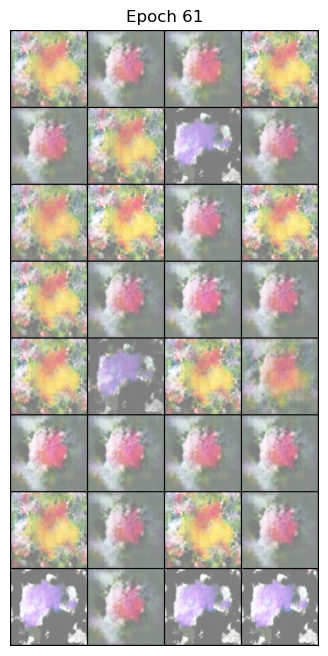

Epoch [62/200] Batch [0/54] D_loss: 1.2447, G+SE_loss: 1.5281
Epoch [62/200] Batch [50/54] D_loss: 1.4134, G+SE_loss: 2.3305
Epoch [62/200] Avg D_loss: 1.5104, Avg G+SE_loss: 2.8724
Epoch [63/200] Batch [0/54] D_loss: 1.1418, G+SE_loss: 2.6817
Epoch [63/200] Batch [50/54] D_loss: 1.0475, G+SE_loss: 2.6723
Epoch [63/200] Avg D_loss: 1.2656, Avg G+SE_loss: 2.4635
Epoch [64/200] Batch [0/54] D_loss: 1.2021, G+SE_loss: 2.1986
Epoch [64/200] Batch [50/54] D_loss: 1.0257, G+SE_loss: 2.8952
Epoch [64/200] Avg D_loss: 1.2520, Avg G+SE_loss: 2.5956
Epoch [65/200] Batch [0/54] D_loss: 1.9108, G+SE_loss: 0.6041
Epoch [65/200] Batch [50/54] D_loss: 1.3858, G+SE_loss: 1.6852
Epoch [65/200] Avg D_loss: 1.4328, Avg G+SE_loss: 2.5403
Epoch [66/200] Batch [0/54] D_loss: 1.0609, G+SE_loss: 2.2157
Epoch [66/200] Batch [50/54] D_loss: 1.2110, G+SE_loss: 1.3823
Epoch [66/200] Avg D_loss: 1.2512, Avg G+SE_loss: 2.3260
Epoch [67/200] Batch [0/54] D_loss: 1.2027, G+SE_loss: 2.1691
Epoch [67/200] Batch [50/54]

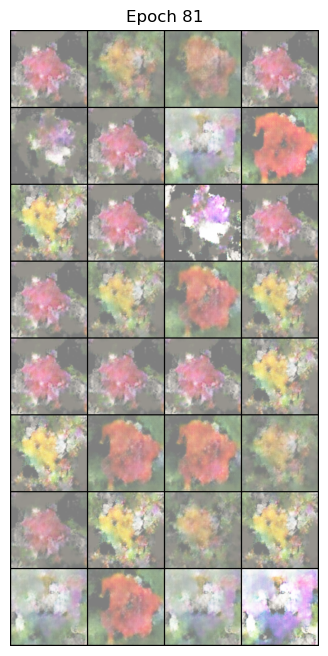

Epoch [82/200] Batch [0/54] D_loss: 1.3267, G+SE_loss: 2.8775
Epoch [82/200] Batch [50/54] D_loss: 1.5899, G+SE_loss: 1.5608
Epoch [82/200] Avg D_loss: 1.2779, Avg G+SE_loss: 2.5013
Epoch [83/200] Batch [0/54] D_loss: 1.2322, G+SE_loss: 2.5524
Epoch [83/200] Batch [50/54] D_loss: 1.2494, G+SE_loss: 1.4717
Epoch [83/200] Avg D_loss: 1.2327, Avg G+SE_loss: 2.4818
Epoch [84/200] Batch [0/54] D_loss: 1.1186, G+SE_loss: 1.7773
Epoch [84/200] Batch [50/54] D_loss: 1.2169, G+SE_loss: 1.7725
Epoch [84/200] Avg D_loss: 1.3020, Avg G+SE_loss: 2.5266
Epoch [85/200] Batch [0/54] D_loss: 1.2030, G+SE_loss: 2.3331
Epoch [85/200] Batch [50/54] D_loss: 1.1803, G+SE_loss: 2.0045
Epoch [85/200] Avg D_loss: 1.5707, Avg G+SE_loss: 2.4840
Epoch [86/200] Batch [0/54] D_loss: 1.0526, G+SE_loss: 2.7459
Epoch [86/200] Batch [50/54] D_loss: 1.3506, G+SE_loss: 2.6406
Epoch [86/200] Avg D_loss: 1.3104, Avg G+SE_loss: 2.5817
Epoch [87/200] Batch [0/54] D_loss: 1.3154, G+SE_loss: 3.6608
Epoch [87/200] Batch [50/54]

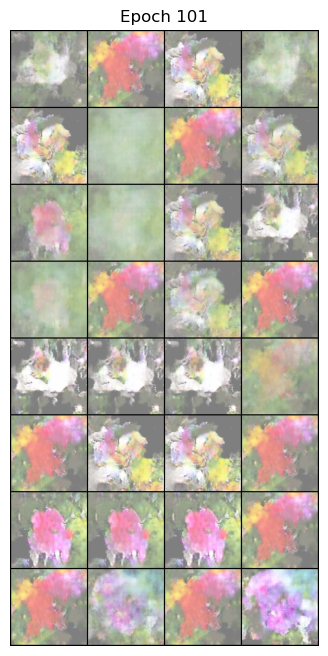

Epoch [102/200] Batch [0/54] D_loss: 1.4123, G+SE_loss: 1.4981
Epoch [102/200] Batch [50/54] D_loss: 1.1492, G+SE_loss: 2.9561
Epoch [102/200] Avg D_loss: 1.1511, Avg G+SE_loss: 2.5400
Epoch [103/200] Batch [0/54] D_loss: 1.9147, G+SE_loss: 0.6795
Epoch [103/200] Batch [50/54] D_loss: 1.2795, G+SE_loss: 1.4663
Epoch [103/200] Avg D_loss: 1.3305, Avg G+SE_loss: 2.5869
Epoch [104/200] Batch [0/54] D_loss: 1.1605, G+SE_loss: 2.6383
Epoch [104/200] Batch [50/54] D_loss: 1.3675, G+SE_loss: 1.6409
Epoch [104/200] Avg D_loss: 1.2433, Avg G+SE_loss: 2.5608
Epoch [105/200] Batch [0/54] D_loss: 1.2034, G+SE_loss: 3.8748
Epoch [105/200] Batch [50/54] D_loss: 1.3658, G+SE_loss: 1.7357
Epoch [105/200] Avg D_loss: 1.2412, Avg G+SE_loss: 2.6545
Epoch [106/200] Batch [0/54] D_loss: 1.1966, G+SE_loss: 3.1376
Epoch [106/200] Batch [50/54] D_loss: 1.0444, G+SE_loss: 2.2882
Epoch [106/200] Avg D_loss: 1.2549, Avg G+SE_loss: 2.5973
Epoch [107/200] Batch [0/54] D_loss: 1.1669, G+SE_loss: 3.5988
Epoch [107/2

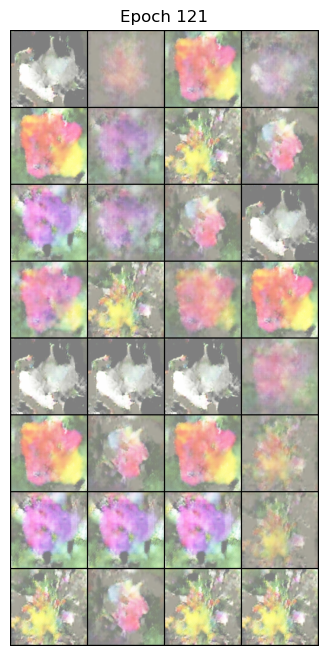

Epoch [122/200] Batch [0/54] D_loss: 1.2467, G+SE_loss: 3.1899
Epoch [122/200] Batch [50/54] D_loss: 1.3294, G+SE_loss: 1.8194
Epoch [122/200] Avg D_loss: 1.1985, Avg G+SE_loss: 2.6543
Epoch [123/200] Batch [0/54] D_loss: 2.0253, G+SE_loss: 4.9764
Epoch [123/200] Batch [50/54] D_loss: 1.0194, G+SE_loss: 1.8931
Epoch [123/200] Avg D_loss: 1.1579, Avg G+SE_loss: 2.5310
Epoch [124/200] Batch [0/54] D_loss: 2.8396, G+SE_loss: 1.9724
Epoch [124/200] Batch [50/54] D_loss: 1.0677, G+SE_loss: 1.9782
Epoch [124/200] Avg D_loss: 1.1928, Avg G+SE_loss: 2.4819
Epoch [125/200] Batch [0/54] D_loss: 1.0790, G+SE_loss: 2.4654
Epoch [125/200] Batch [50/54] D_loss: 1.0308, G+SE_loss: 2.0738
Epoch [125/200] Avg D_loss: 1.2121, Avg G+SE_loss: 2.6040
Epoch [126/200] Batch [0/54] D_loss: 1.2853, G+SE_loss: 2.6567
Epoch [126/200] Batch [50/54] D_loss: 1.0473, G+SE_loss: 2.5439
Epoch [126/200] Avg D_loss: 1.1453, Avg G+SE_loss: 2.4743
Epoch [127/200] Batch [0/54] D_loss: 1.6425, G+SE_loss: 5.3420
Epoch [127/2

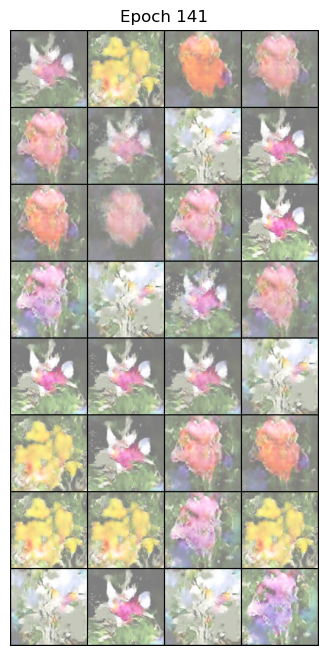

Epoch [142/200] Batch [0/54] D_loss: 1.2053, G+SE_loss: 1.4210
Epoch [142/200] Batch [50/54] D_loss: 1.2436, G+SE_loss: 1.3207
Epoch [142/200] Avg D_loss: 1.1351, Avg G+SE_loss: 2.4974
Epoch [143/200] Batch [0/54] D_loss: 1.3354, G+SE_loss: 3.4711
Epoch [143/200] Batch [50/54] D_loss: 1.1879, G+SE_loss: 1.7711
Epoch [143/200] Avg D_loss: 1.1155, Avg G+SE_loss: 2.4910
Epoch [144/200] Batch [0/54] D_loss: 1.4340, G+SE_loss: 1.8128
Epoch [144/200] Batch [50/54] D_loss: 1.1771, G+SE_loss: 3.4650
Epoch [144/200] Avg D_loss: 1.1396, Avg G+SE_loss: 2.4998
Epoch [145/200] Batch [0/54] D_loss: 1.1615, G+SE_loss: 2.2788
Epoch [145/200] Batch [50/54] D_loss: 1.1400, G+SE_loss: 3.2107
Epoch [145/200] Avg D_loss: 1.2872, Avg G+SE_loss: 2.5895
Epoch [146/200] Batch [0/54] D_loss: 1.3555, G+SE_loss: 1.7290
Epoch [146/200] Batch [50/54] D_loss: 1.0722, G+SE_loss: 2.7428
Epoch [146/200] Avg D_loss: 1.0906, Avg G+SE_loss: 2.4717
Epoch [147/200] Batch [0/54] D_loss: 1.0462, G+SE_loss: 3.1181
Epoch [147/2

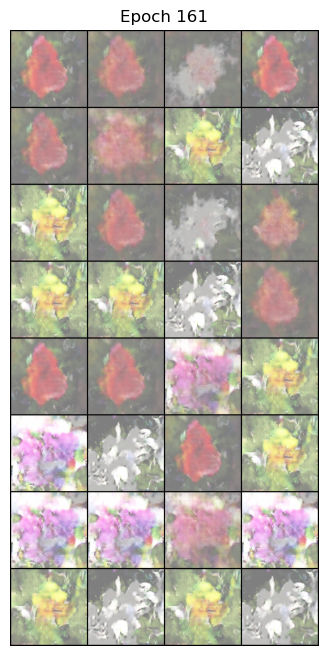

Epoch [162/200] Batch [0/54] D_loss: 1.0601, G+SE_loss: 2.3964
Epoch [162/200] Batch [50/54] D_loss: 1.5412, G+SE_loss: 3.7413
Epoch [162/200] Avg D_loss: 1.1044, Avg G+SE_loss: 2.4809
Epoch [163/200] Batch [0/54] D_loss: 1.1811, G+SE_loss: 2.8681
Epoch [163/200] Batch [50/54] D_loss: 1.1523, G+SE_loss: 2.5128
Epoch [163/200] Avg D_loss: 1.1889, Avg G+SE_loss: 2.5231
Epoch [164/200] Batch [0/54] D_loss: 1.0677, G+SE_loss: 2.5433
Epoch [164/200] Batch [50/54] D_loss: 0.9743, G+SE_loss: 3.1664
Epoch [164/200] Avg D_loss: 1.0909, Avg G+SE_loss: 2.5611
Epoch [165/200] Batch [0/54] D_loss: 1.0138, G+SE_loss: 3.1307
Epoch [165/200] Batch [50/54] D_loss: 1.1251, G+SE_loss: 2.1374
Epoch [165/200] Avg D_loss: 1.1396, Avg G+SE_loss: 2.5358
Epoch [166/200] Batch [0/54] D_loss: 1.0986, G+SE_loss: 2.2792
Epoch [166/200] Batch [50/54] D_loss: 1.3025, G+SE_loss: 1.8679
Epoch [166/200] Avg D_loss: 1.1682, Avg G+SE_loss: 2.6334
Epoch [167/200] Batch [0/54] D_loss: 1.0981, G+SE_loss: 2.2573
Epoch [167/2

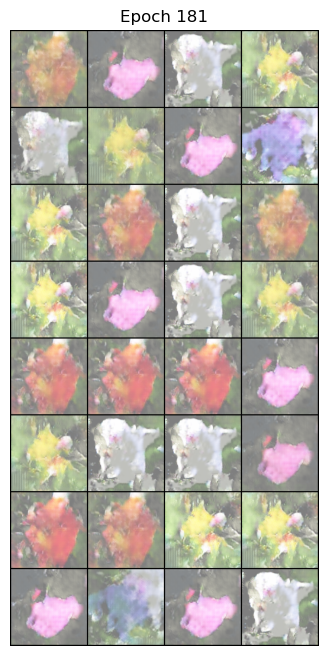

Epoch [182/200] Batch [0/54] D_loss: 1.0366, G+SE_loss: 2.3301
Epoch [182/200] Batch [50/54] D_loss: 1.1253, G+SE_loss: 3.2602
Epoch [182/200] Avg D_loss: 1.1326, Avg G+SE_loss: 2.5468
Epoch [183/200] Batch [0/54] D_loss: 1.2310, G+SE_loss: 2.4607
Epoch [183/200] Batch [50/54] D_loss: 1.3815, G+SE_loss: 4.2574
Epoch [183/200] Avg D_loss: 1.0753, Avg G+SE_loss: 2.4752
Epoch [184/200] Batch [0/54] D_loss: 1.0135, G+SE_loss: 2.3795
Epoch [184/200] Batch [50/54] D_loss: 1.0645, G+SE_loss: 2.0905
Epoch [184/200] Avg D_loss: 1.0594, Avg G+SE_loss: 2.4878
Epoch [185/200] Batch [0/54] D_loss: 1.5041, G+SE_loss: 3.9514
Epoch [185/200] Batch [50/54] D_loss: 1.0431, G+SE_loss: 2.3471
Epoch [185/200] Avg D_loss: 1.1334, Avg G+SE_loss: 2.5834
Epoch [186/200] Batch [0/54] D_loss: 1.0333, G+SE_loss: 2.2694
Epoch [186/200] Batch [50/54] D_loss: 0.9968, G+SE_loss: 2.0858
Epoch [186/200] Avg D_loss: 1.0631, Avg G+SE_loss: 2.4165
Epoch [187/200] Batch [0/54] D_loss: 1.0427, G+SE_loss: 2.0854
Epoch [187/2

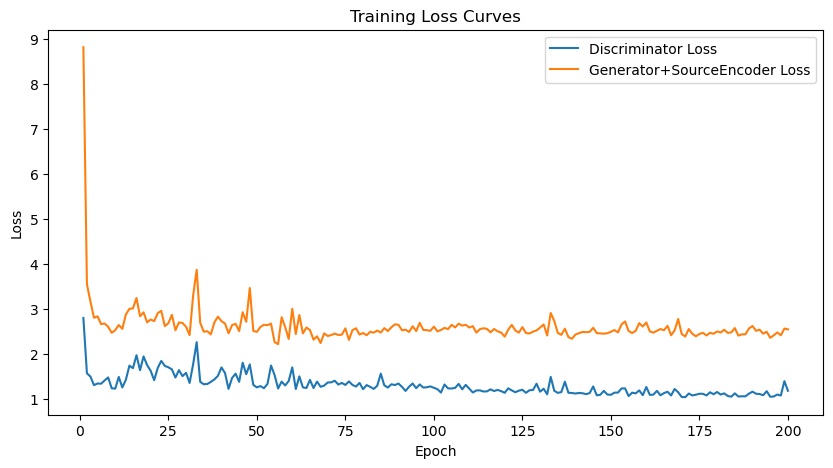

In [64]:

train_conditional_gan(epochs=200, dataloader=train_dataloader, source_encoder=sourceEncoder,
                        generator=generator, discriminator=discriminator, device=device)

### Inference and Testing Section

In [80]:
def plot_tsne(encoder, dataloader, device):
    """
    Plots a 3D t-SNE visualization of the feature embeddings extracted by the source encoder.

    Parameters:
        encoder (torch.nn.Module): The source encoder network.
        dataloader (DataLoader): DataLoader providing batches of (images, text_embeddings, labels).
        device (torch.device): The device (CPU/GPU) to run the training on.

    Forward Pass:
        - The source encoder extracts features from images in the dataset.
        - t-SNE is applied to the extracted features to reduce them to 3 dimensions.
        - The 3D features are plotted in a 3D scatter plot with class labels.

    """

    encoder.to(device)
    encoder.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, text_embeddings, batch_labels in dataloader:
            images = images.to(device)
            text_embeddings = text_embeddings.to(device)
            features_batch = encoder(images)
            features.extend(features_batch.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())
    features = np.array(features)
    labels = np.array(labels)

    tsne = TSNE(n_components=3, max_iter=3000, perplexity=100)
    features_tsne = tsne.fit_transform(features)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    for class_idx in np.unique(labels):
        idx = labels == class_idx
        ax.scatter(features_tsne[idx, 0], features_tsne[idx, 1], features_tsne[idx, 2], label=class_idx)
    ax.legend()
    plt.show()



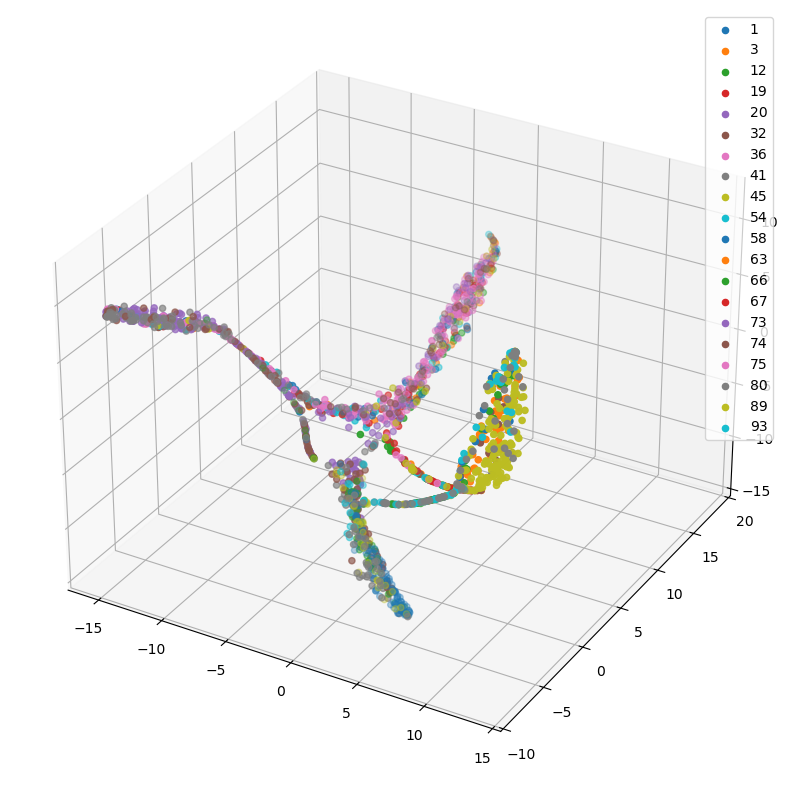

In [81]:
plot_tsne(sourceEncoder, train_dataloader, device)

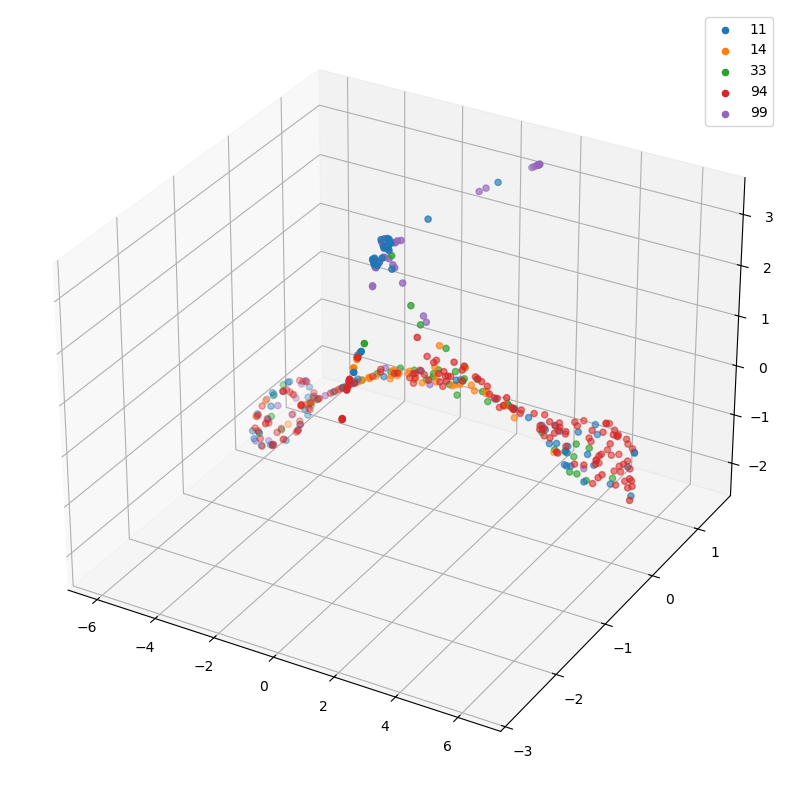

In [82]:
# plot test tsne 
plot_tsne(sourceEncoder, test_dataloader, device)


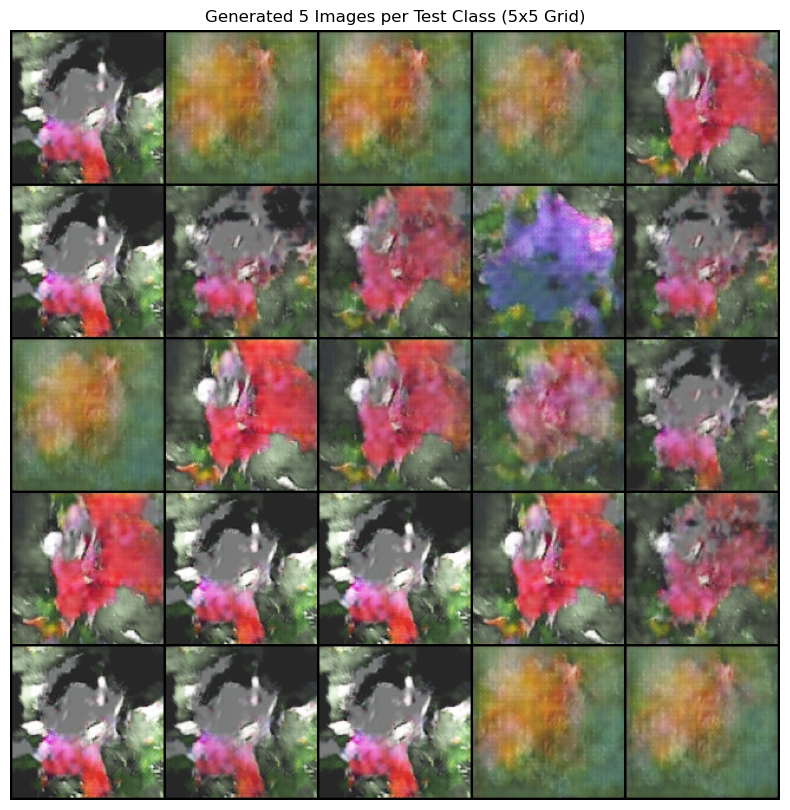

In [68]:
def generate_5_images_each_class(test_dataloader, source_encoder, generator, device, images_per_class=5):
    """
    Generate 5 fake images per test class and arrange them in a 5x5 grid.

    Args:
        test_dataloader: DataLoader yielding (images, text_embeddings, labels).
        source_encoder: Model that converts real images to a [B, 1024] feature vector.
        generator: Model that takes a latent vector (concatenation of source features and text embeddings)
                   and outputs a fake image (e.g., [B, 3, 128, 128]).
        device: torch.device.
        images_per_class: Number of generated images to collect per class (default is 5).
    
    Returns:
        grid: A tensor grid image containing the arranged generated images.
    """
    

    source_encoder.eval()
    generator.eval()
    
    
    gen_images_by_class = {} 
    
    with torch.no_grad():
        for images, text_embeddings, labels in test_dataloader:
            images = images.to(device)
            text_embeddings = text_embeddings.to(device)
            # If text embeddings have an extra dimension, select the first embedding.
            if text_embeddings.dim() == 3:
                text_embeddings = text_embeddings[:, 0, :]
            
            # Pass images through the source encoder to get features
            features = source_encoder(images)  # Expected shape: [B, 1024]
            # Concatenate features with text embeddings; expect both to be [B, 1024]
            latent = torch.cat([features, text_embeddings], dim=1)  # Shape: [B, 2048]
            fake_images = generator(latent)  # Generated images: [B, 3, 128, 128]
            
            # Loop over the batch and collect images by label
            for img, label in zip(fake_images.cpu(), labels):
                label = int(label)
                if label not in gen_images_by_class:
                    gen_images_by_class[label] = []
                if len(gen_images_by_class[label]) < images_per_class:
                    gen_images_by_class[label].append(img)
            
            # Stop once we have collected enough images for each class (assume 5 classes)
            if len(gen_images_by_class) >= 5 and all(len(v) >= images_per_class for v in gen_images_by_class.values()):
                break

    # Prepare rows: one row per class (sorted by class label)
    rows = []
    for label in sorted(gen_images_by_class.keys()):
        # Ensure we have exactly images_per_class images (if more, take the first ones)
        imgs = gen_images_by_class[label][:images_per_class]
        # Stack images to form a row tensor of shape [images_per_class, 3, 128, 128]
        row = torch.stack(imgs, dim=0)
        rows.append(row)
    
    all_images = torch.cat(rows, dim=0)
    # Make a grid: nrow equals images_per_class so that each row corresponds to one class.
    grid = vutils.make_grid(all_images, nrow=images_per_class, padding=2, normalize=True)
    
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.title("Generated 5 Images per Test Class (5x5 Grid)")
    plt.imshow(grid.permute(1,2,0).numpy())
    plt.show()
    
    return grid


grid = generate_5_images_each_class(test_dataloader, sourceEncoder, generator, device)



### Memory and parameter profiling

In [ ]:

def get_model_size(model):
    """
    Returns the size (in bytes) of the given model's state_dict when saved to disk.
    
    Args:
        model (torch.nn.Module): The model to measure.
    
    Returns:
        int: Size in bytes.
    """
    buffer = io.BytesIO()
    torch.save(model.state_dict(), buffer)
    return buffer.getbuffer().nbytes

def print_model_summary(models, model_names):
    """
    Prints a table summarizing the total number of parameters, trainable parameters, and the model size (in MB)
    for a list of models.
    
    Args:
        models (list): List of torch.nn.Module objects.
        model_names (list): List of names corresponding to the models.
    """
    # Table header
    header = "{:<20} {:>20} {:>25} {:>25}".format("Model", "Total Params", "Trainable Params", "Size on Disk (MB)")
    print(header)
    print("-" * len(header))
    
    for model, name in zip(models, model_names):
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        size_bytes = get_model_size(model)
        size_mb = size_bytes / (1024 * 1024)
        row = "{:<20} {:>20} {:>25} {:>25.2f}".format(name, total_params, trainable_params, size_mb)
        print(row)

# Example usage:
# Assume you have already defined and instantiated:
#    source_encoder, generator, discriminator
models = [sourceEncoder, generator, discriminator]
model_names = ["SourceEncoder", "Generator", "Discriminator"]

print_model_summary(models, model_names)


Model                        Total Params          Trainable Params         Size on Disk (MB)
---------------------------------------------------------------------------------------------
SourceEncoder                    23085120                  23085120                     88.16
Generator                         8436208                   8436208                     32.19
Discriminator                     2790144                   2790144                     10.66
